# Your Community Eatery

## Welcome to your local (if you're in Phoenix) restaurant recommender! 

We are going to take a walk through the process of creating a recommender based on collaborative filtering of Yelp review data. Follow along here for the full story...

In [196]:
# Project specific modules
from src.pipeline import YourCommunityEatery
from src.functions import build_item_map

# Avoid restarting Kernal each time we update modules
%load_ext autoreload
%autoreload 2

# The basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Spark library and functions
import pyspark as ps
import pyspark.sql.types as types
from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import to_timestamp

# Sklearn Modeling
from sklearn.model_selection import train_test_split


# Surprise modeling
from surprise import SVD
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Persistance
import pickle

# Housekeeping
from io import StringIO
from datetime import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initial EDA

This dataset is actually too big to simply load into a Pandas dataframe (at least on my machine - 8 GB memory). Although I know people with 16 GB machines have loaded it successfully, so far I get memory errors when trying to load it onto a 16 GB AWS EC2 instance (and I'm still searching for an answer/solution on that). Regardless, we can do some initial EDA to just see what we have by using Spark!

In [35]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )

review_df = spark.read.json("data/review.json")
# checkin_df = spark.read.json("data/checkin.json")
# tip_df = spark.read.json("data/tip.json")
# user_df = spark.read.json("data/user.json")
business_df = spark.read.json("data/business.json")

We plan to work with the review and business datasets. So let's see how many distinct values for all fields we have on those.

Number of states covered in the data: 36
Number of cities covered in the data: 1204


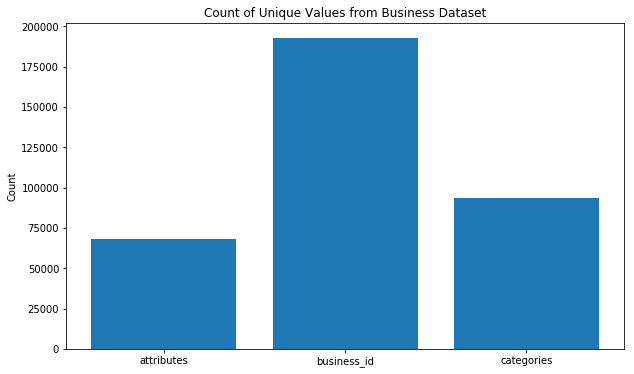

In [61]:
this = business_df.agg(*(countDistinct(col(c)).alias(c) for c in business_df.columns))
this = this.take(1)[0].asDict()

print('Number of states covered in the data: {}'.format(this['state']))
print('Number of cities covered in the data: {}'.format(this['city']))

drop_list = ['city', 'state', 'address', 'hours', 'is_open', 
             'latitude', 'longitude', 'name', 'postal_code', 
             'review_count', 'stars']
for _ in drop_list:
    this.pop(_)

fig, ax = plt.subplots(figsize = (10, 6))
ax.bar(range(len(this)), list(this.values()), align='center')
ax.set_title('Count of Unique Values from Business Dataset')
ax.set_ylabel('Count')
_ = plt.xticks(range(len(this)), list(this.keys()))

Number of businesses covered in the review data: 192606


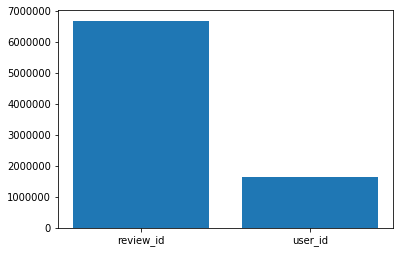

In [68]:
this = review_df.agg(*(countDistinct(col(c)).alias(c) for c in review_df.columns))
this = this.take(1)[0].asDict()

print('Number of businesses covered in the review data: {}'.format(this['business_id']))

drop_list = ['cool', 'funny', 'useful', 'text', 'stars', 'date', 'business_id']
for _ in drop_list:
    this.pop(_)

plt.bar(range(len(this)), list(this.values()), align='center')
_ = plt.xticks(range(len(this)), list(this.keys()))

## We would like to develop a restaurant recommender for one metropolitan area

Given that we are developing a similarity/collaborative-filtering based recommender, we are going to limit this project to one geographic area since there wouldn't be much if any signal on one geo for another. Also, given the demands of this dataset, it will be much more manageable to filter it down to one city so we can simply work with Pandas. But which region to pick?

Let's look at some density metrics to decide...

In [63]:
def calculate_region_density(state, businesses, bus_reviews):
    num_businesses = businesses.filter((businesses.categories.like('%Restaurants%')) &
                                (business_df.state == state)).count()
    num_reviews = bus_reviews.filter((bus_reviews.categories.like('%Restaurants%')) &
                                (bus_reviews.state == state)).count()
    return num_reviews/num_businesses

def compare_region_densities(regions, businesses, bus_reviews):
    max_density = 0
    density_dict = {}
    for region in regions:
        density = calculate_region_density(region, businesses, bus_reviews)
        density_dict[region] = density
        if density > max_density:
            max_density = density
            max_region = region

    print('Best Region: {}\nBest Density: {}'.format(max_region, max_density))
    return density_dict

In [66]:
# Join business and review df's so that we can really look at this
bus_review_df = review_df.join(business_df, 
                               review_df.business_id == business_df.business_id,
                                how='left')

Best Region: NV
Best Density: 178.80932802261339


Text(0.5, 1.0, 'Review Density by Region')

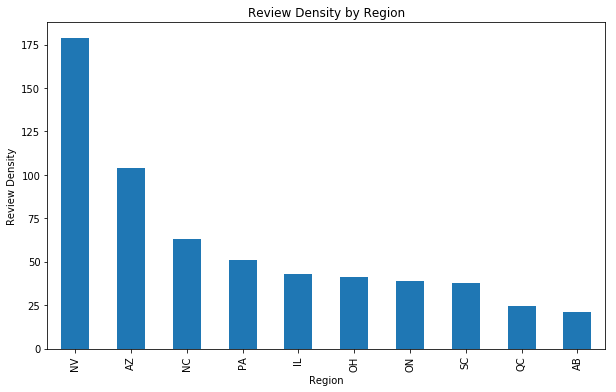

In [67]:
regions = ['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'IL', 'SC', 'QC']

density_dict = compare_region_densities(regions, business_df, bus_review_df)

pd.DataFrame.from_dict(density_dict, orient = 'index').sort_values(0, ascending = False).plot.bar(legend = False, figsize = (10, 6))
plt.ylabel('Review Density')
plt.xlabel('Region')
plt.title('Review Density by Region')

## The winner: Arizona

We are proceeding with Arizona based businesses for this case study. Although Nevada has a greater density of reviews/restaurant, this data scientist considers it to be an anomaly in the restaurant space as well as user space given the impact tourism would have on restaurant visits/reviews. Arizona has the next highest density, would be expected to include a healthy mix of resident and non-resident reviews, most reviews are concentrated around Phoenix, and we would expect Phoenix to have a diverse group of users. Note that it was specified by Yelp that their dataset focuses on 8 metropolitan areas, and we have validated (though not shown here) that the Arizona locations are in/around Phoenix.

Now that we have a region in mind, we will be able to fit the subject piece of the dataset into memory in Pandas.

But don't forget to close Spark!

In [70]:
spark.stop()

# Loading Data into Pandas - Pipeline Demo

Now that we have a few criteria on which to select a limited volume of the data (Restaurants and Arizona), our subject dataset will be much more manageable and will easily fit in memory. We've developed a pipeline just for handling this!

In [153]:
# Instantiate object specifying that we don't have the memory to handle the full dataset
pipe = YourCommunityEatery(save_memory=True)

In [158]:
# Read data in from files 
# There is quite a bit of data to load and it has to be filtered 
# based on some conditions to fit in memory, so this takes a while
pipe.read_data(data_dir_path='data/')

In [208]:
# Alternatively, you can just load it from a file!
# This isn't super fast, but much beter than the above.
pipe.bus_review_df = pd.read_pickle('data/bus_review_df.pkl')

# Now that we have our data, let's delve into some additional EDA
#### At this point our data is saved in 'bus_review_df' which is an attribute of our pipe object

What time frame do these reviews span?

In [161]:
begin = pipe.bus_review_df.date.min()
end = pipe.bus_review_df.date.max()
print('These ratings range from {} to {}.'.format(begin.year, end.year))

These ratings range from 2005 to 2018.


Long span of data, nice! And what kind of distribution of reviews over time might we see for that duration?

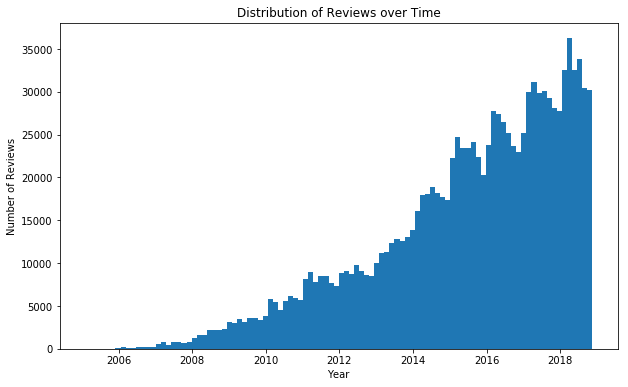

In [162]:
ax = pipe.bus_review_df.date.hist(bins = 100, figsize = (10, 6))
ax.grid(False)
ax.set_title('Distribution of Reviews over Time')
ax.set_xlabel('Year')
_ = ax.set_ylabel('Number of Reviews')

Look at that growth! Good for you, Yelp. Interesting trends after 2015, seasonality for reviews? Interesting...but out of our scope.

What is the distribution of number of users to have reviewed each restaurant? 


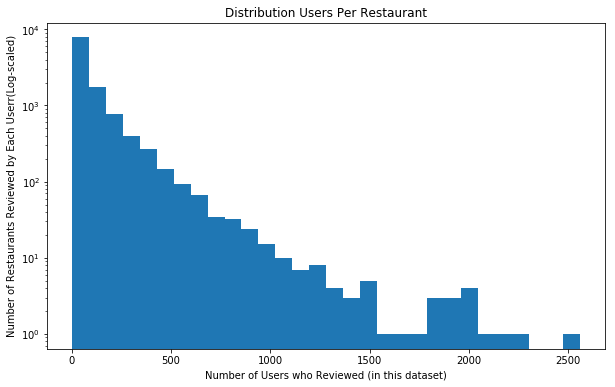

In [163]:
groups = pipe.bus_review_df.groupby('business_id')
ax = groups.user_id.nunique().hist(bins = 30, figsize = (10, 6))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Users who Reviewed (in this dataset)')
ax.set_title('Distribution Users Per Restaurant')
_ = ax.set_ylabel('Number of Restaurants Reviewed by Each Userr(Log-scaled)')

Keeping in mind this is log-scaled on the y axis, this data appears to be exponentially distributed.


What is the distribution of reviews per user?


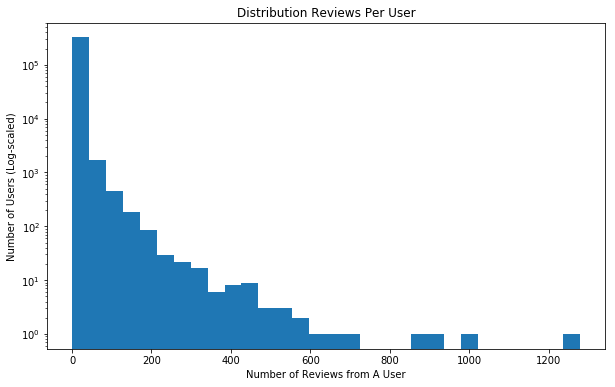

In [164]:
groups = pipe.bus_review_df.groupby('user_id')
ax = groups.review_id.nunique().hist(bins = 30, figsize = (10, 6))
ax.grid(False)
ax.set_yscale('log')
ax.set_xlabel('Number of Reviews from A User')
ax.set_title('Distribution Reviews Per User')
_ = ax.set_ylabel('Number of Users (Log-scaled)')

From the graph above, we are able to see that this is exponentially distributed. There are several users who have made significant numbers of reviews. Normally this might be cause for concern that their reviews are not legitimate; however, this dataset consists only of reviews that Yelp has validated and "recommended", so they are likely just very passionate about food. But skeptical scientists that we are, we'll not just take their word for it...ok, I admit that I'm mostly just curious to see what kind of stuff a person who writes over 1,200 reviews has to say.

Let's verify the text of the highest volume user to be sure they are not a bot. As shown below, only one user exceeded 1000 reviews and their id is 'ELcQDlf69kb-ihJfxZyL0A'. Feel free to adjust the index on the .iloc to see a few different reivews (just put in a number between 0 and 1277).

In [77]:
pipe.bus_review_df[pipe.bus_review_df.user_id == 'ELcQDlf69kb-ihJfxZyL0A'].text.iloc[356]

"My date said the place smelled like onions when we walked inside. It did a bit, but it eventually faded away. The date got some four cheese flatbread pizza which looked decent and my flatbread blackened chicken sandwich was actually pretty tasty. It had some orange sauce (chipotle?) that really upgraded the level of taste. The fries were hot and firm, not like my 50 year old date's body, but can't win them all. The bud light was 3 bucks and reverse happy hour was kicking off at 9pm which meant cheaper beer and food specials. The bartendress was attractive and we both could not help but to stare. A good location for this chain and not too crowded due to the family area it is located."

...ok, review for index 356 is pretty shameful. But clearly, this is not a bot...just definitely someone who has a lot of time on their hands. Outlier though they may be, their reviews appear to be genuine, so we will graciously accept their contributions to our density.

## In  planning for a collaborative-filtering based recommender, we need to take a look at our density of reviews

In [198]:
density = pipe.calculate_density()
print('The density of our data is {:.6f}'.format(density))

Number of  ratings: 1191691
Number of items: 11465
Number of ratings: 324853
The density of our data is 0.000320


Ouch, that is extremely low. Let's take a look at how we might improve that at least slightly.

## For model training, let's consider trimming down our dataset to increase density

Normally, taking samples of your data to increase density is a non-starter, but we may have some clever ways of taking samples based on what we've learned so far. Let's start with getting later time periods, since we have far more reviews in the later segment of the data. We will use the "filter_by_review_date" method to modify our dataframe in place to only include reviews during-or-after a specified year.

In [200]:
pipe.filter_by_review_date(threshold = 2013)

In [201]:
density = pipe.calculate_density()
print('The density of our data is {:.6f}'.format(density))

Number of  ratings: 983449
Number of items: 10303
Number of ratings: 298385
The density of our data is 0.000320


As it turns out, the density is not significantly affected by taking slices for more recent data. We did this for all year thresholds from 2005 through 2017 and found that we were only able to achieve a change of about 10% from the above figure, and it was for the worse. It is not being shown here because the dataframe gets modified in place, and we'd like to spare you from having to reload it to get back to normal. Let's proceed with a threshold of 2013 for the sake of having some value for recency without sacrificing too much data.

It is expected that the restaurants and users with low counts of reviews are making our user-restaurant matrix too sparse. Let's cut off those density killers and re-evaluate some of these metrics.

In [4]:
thresholds = [2, 3, 4, 5, 6, 7]
for thresh in thresholds:
    groups = pipe.bus_review_df.groupby('user_id')
    user_selection = groups.review_id.nunique()>=thresh
    user_selection = user_selection[user_selection]
    trimmed_df = pipe.bus_review_df[pipe.bus_review_df.user_id.isin(user_selection.index)]

    full = len(pipe.bus_review_df)
    trimmed = len(trimmed_df)
    print('Removing users with less than {} reviews leaves us with {:.2f}% of the original amount of reviews.'.format(thresh, 100*(trimmed)/full))

Removing users with less than 2 reviews leaves us with 85.38% of the original amount of reviews.
Removing users with less than 3 reviews leaves us with 76.13% of the original amount of reviews.
Removing users with less than 4 reviews leaves us with 69.32% of the original amount of reviews.
Removing users with less than 5 reviews leaves us with 63.92% of the original amount of reviews.
Removing users with less than 6 reviews leaves us with 59.53% of the original amount of reviews.
Removing users with less than 7 reviews leaves us with 55.79% of the original amount of reviews.


In [5]:
business_thresholds = [5, 10, 20, 30, 40, 50]

for thresh in business_thresholds:
    groups = pipe.bus_review_df.groupby('business_id')
    business_selection = groups.user_id.nunique()>=thresh
    business_selection = business_selection[business_selection]
    trimmed_df = pipe.bus_review_df[pipe.bus_review_df.business_id.isin(business_selection.index)]

    full = len(pipe.bus_review_df)
    trimmed = len(trimmed_df)
    print('Removing businesses reviewed by less than {} users leaves us with {:.2f}% of the original amount of reviews.'.format(thresh, 100*(trimmed)/full))

Removing businesses reviewed by less than 5 users leaves us with 99.75% of the original amount of reviews.
Removing businesses reviewed by less than 10 users leaves us with 98.95% of the original amount of reviews.
Removing businesses reviewed by less than 20 users leaves us with 96.90% of the original amount of reviews.
Removing businesses reviewed by less than 30 users leaves us with 94.58% of the original amount of reviews.
Removing businesses reviewed by less than 40 users leaves us with 92.45% of the original amount of reviews.
Removing businesses reviewed by less than 50 users leaves us with 90.23% of the original amount of reviews.


### Based on these results, we are selecting based on the following:
* Only including reviews for businesses that have been reviewed by at least 50 users
* Only including reviews for users that have reviewed at least 4 restaurants

We can ue the built-in methods to accomplish this! But note that these operations are performed in series, and each one will affect ther other. That is, if we first filter out users with less than 4 reviews and then filter out restaurants with less than 50 reviews, we end up eliminating some restaurants that were counting as the 4th review for some of those users. 

As a result, our final dataframe would include only 3 reviews (or even less) for certain users. Given the low values for this threshold, this will quickly hurt our density (dropping 1 review from a user is a 25% drop for that user). As such, it's beneficial to perform the filtering on businesses first, as we have some room to spare with them (if we end up with businesses with only 45 reviews instead of 50, it's not as big of a deal).

In [148]:
pipe.filter_low_density_items(threshold=50)
pipe.bus_review_df.groupby('business_id').count().user_id.min()

In [ ]:
pipe.filter_low_density_users(threshold=4)
pipe.bus_review_df.groupby('user_id').count().review_id.min()

And now let's check the minimum number of users that have reviewed a retaurant in our remaining dataset to be sure that it is reasonably close to 50:

In [151]:
pipe.bus_review_df.groupby('business_id').count().user_id.min()

10

In [150]:
pipe.bus_review_df.groupby('business_id').count().user_id.min()

4

In [152]:
density = pipe.calculate_density()
print('The density of our data is {:.5f}'.format(density))

The density of our data is 0.00224


In [ ]:
# Save to json
pipe.persist_subject_data('../data/test_df')